In [13]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm, trange  # to visualize progress

from PMCPnP import PMCPnPAnnealing, PMCPnP
from PMCPnP import PMCPnPIterator, PMCPnPAnnealingIterator
from utils import get_blur_physics, get_inpainting_physics

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("butterfly.png")
img_size = 256
x_true = load_url_image(url=url, img_size=img_size).to(device)
x = x_true.clone()

%load_ext autoreload
%autoreload 2

Selected GPU 0 with 23189 MB free memory 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


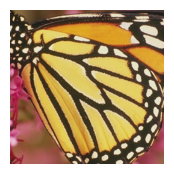

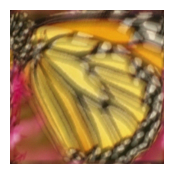

In [46]:
sigma = 0.01  # noise level

physics = get_blur_physics(sigma, device)

#physics = get_inpainting_physics(img_size, sigma, device)

torch.manual_seed(0)

# load Gaussian Likelihood

y = physics(x)
plot(x_true.detach().cpu())
plot(y)

## Classic PnP

In [51]:
gamma = 1e-5
alpha = 1
iterations = int(1e3) if torch.cuda.is_available() else 10
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
print(gamma)
print(sigma_denoiser)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    denoiser=dinv.models.DRUNet(pretrained="download")
    #denoiser=dinv.models.DiffUNet(large_model=False)
).to(device)


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,
                 deterministic = True,
                 Himbert = False,
                 )




1e-05
0.00670820393249937


#### Déterministe 

In [57]:
gamma = 1e-5
alpha = 1
iterations = int(1e3) if torch.cuda.is_available() else 10
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
print(gamma)
print(sigma_denoiser)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    denoiser=dinv.models.DRUNet(pretrained="download")
    #denoiser=dinv.models.DiffUNet(large_model=False)
).to(device)


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,
                 deterministic = True,
                 Himbert = True,
                 )




1e-05
0.00670820393249937


100%|██████████| 1000/1000 [00:31<00:00, 31.44it/s]


Monte Carlo sampling finished! elapsed time=31.82 seconds
Iteration 999, current converge crit. = 1.48E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.79 dB
PreconULA posterior mean PSNR: 24.35 dB


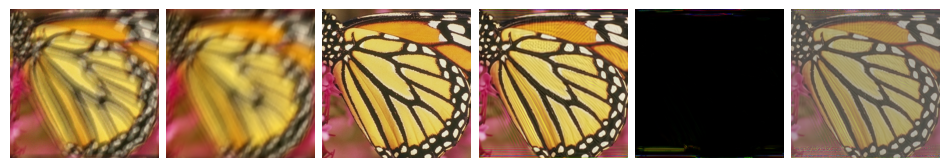

In [58]:
### version Himbert déterministe 

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)


# plot results
imgs = [y, x_lin, x, pula_mean, pula_var, example_sample]
plot(imgs)

100%|██████████| 1000/1000 [00:30<00:00, 32.97it/s]


Monte Carlo sampling finished! elapsed time=30.34 seconds
Iteration 999, current converge crit. = 1.47E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.79 dB
PreconULA posterior mean PSNR: 24.31 dB


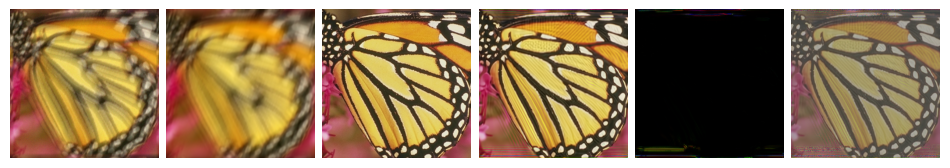

In [52]:
### là avec ma correction, pas version Himbert

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)


# plot results
imgs = [y, x_lin, x, pula_mean, pula_var, example_sample]
plot(imgs)

#### Alea 

In [53]:
gamma = 1e-5
alpha = 1
iterations = int(1e3) if torch.cuda.is_available() else 10
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
print(gamma)
print(sigma_denoiser)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    denoiser=dinv.models.DRUNet(pretrained="download")
    #denoiser=dinv.models.DiffUNet(large_model=False)
).to(device)


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,
                 deterministic = False,
                 Himbert = False,
                 )




1e-05
0.00670820393249937


100%|██████████| 1000/1000 [00:29<00:00, 33.87it/s]


Monte Carlo sampling finished! elapsed time=29.54 seconds
Iteration 999, current converge crit. = 2.80E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.79 dB
PreconULA posterior mean PSNR: 21.15 dB


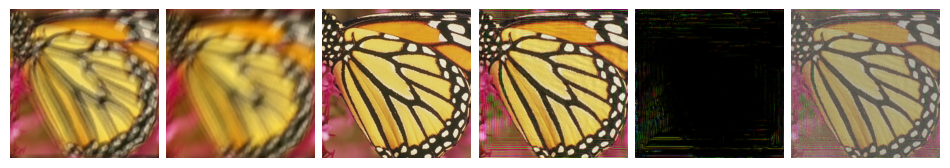

In [54]:
### version Himbert déterministe 

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)


# plot results
imgs = [y, x_lin, x, pula_mean, pula_var, example_sample]
plot(imgs)

### Annealing

In [ ]:
iterations = int(1e3) if torch.cuda.is_available() else 10
gamma = 1e-5
alpha_0 = 100 
sigma_0, sigma_final = .1, np.sqrt(2 * gamma) * 1.5
alphas = [] #linear step from alpha_0 to 1, linearly decreasing for iterations time. Make it a tensor 
sigmas = [] #linear decreasing, from sigma_0 to simga_final, iterations time. Make it a tensor

# pmc_pnp = PMCPnPAnnealing(prior=prior,
#                  data_fidelity=likelihood,
#                  max_iter=iterations,
#                  gamma=gamma,
#                  sigmas=sigmas,
#                  alphas=alphas,)

In [62]:
iterations = int(1e3) if torch.cuda.is_available() else 10
gamma = 1e-5

xsi = 0.99

base_sigma = np.sqrt(2 * gamma) * 10
min_sigma = np.sqrt(2 * gamma)
print(base_sigma, min_sigma)
base_alpha = 1 / (min_sigma**2)
min_alpha = 1
sigmas = torch.Tensor([max(base_sigma * (xsi**i) , min_sigma) for i in range(iterations)])
alphas = torch.Tensor([max(base_alpha * (elem**2), min_alpha) for elem in sigmas]) / 255


# pmc_pnp = PMCPnPAnnealing(prior=prior,
#                  data_fidelity=likelihood,
#                  max_iter=iterations,
#                  gamma=gamma,
#                  sigmas=sigmas,
#                  alphas=alphas,)

0.0447213595499958 0.00447213595499958


In [63]:
alphas

tensor([0.3922, 0.3844, 0.3767, 0.3692, 0.3619, 0.3547, 0.3476, 0.3407, 0.3339,
        0.3273, 0.3207, 0.3144, 0.3081, 0.3020, 0.2960, 0.2901, 0.2843, 0.2786,
        0.2731, 0.2677, 0.2623, 0.2571, 0.2520, 0.2470, 0.2421, 0.2373, 0.2325,
        0.2279, 0.2234, 0.2189, 0.2146, 0.2103, 0.2061, 0.2020, 0.1980, 0.1941,
        0.1902, 0.1864, 0.1827, 0.1791, 0.1755, 0.1720, 0.1686, 0.1652, 0.1619,
        0.1587, 0.1556, 0.1525, 0.1494, 0.1465, 0.1435, 0.1407, 0.1379, 0.1351,
        0.1325, 0.1298, 0.1272, 0.1247, 0.1222, 0.1198, 0.1174, 0.1151, 0.1128,
        0.1105, 0.1083, 0.1062, 0.1041, 0.1020, 0.1000, 0.0980, 0.0960, 0.0941,
        0.0922, 0.0904, 0.0886, 0.0868, 0.0851, 0.0834, 0.0818, 0.0801, 0.0785,
        0.0770, 0.0754, 0.0739, 0.0725, 0.0710, 0.0696, 0.0682, 0.0669, 0.0655,
        0.0642, 0.0630, 0.0617, 0.0605, 0.0593, 0.0581, 0.0569, 0.0558, 0.0547,
        0.0536, 0.0525, 0.0515, 0.0505, 0.0495, 0.0485, 0.0475, 0.0466, 0.0456,
        0.0447, 0.0438, 0.0430, 0.0421, 

## Rest

In [ ]:
gamma = 5e-4
alpha = 1
iterations = int(1e3) if torch.cuda.is_available() else 10
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
print(gamma)
print(sigma_denoiser)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    denoiser=dinv.models.DRUNet(pretrained="download")
    #denoiser=dinv.models.DiffUNet(large_model=False)
).to(device)


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,)




  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:29<00:00, 34.22it/s]


Monte Carlo sampling finished! elapsed time=29.23 seconds
Iteration 999, current converge crit. = 3.60E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.63 dB
PreconULA posterior mean PSNR: 11.21 dB


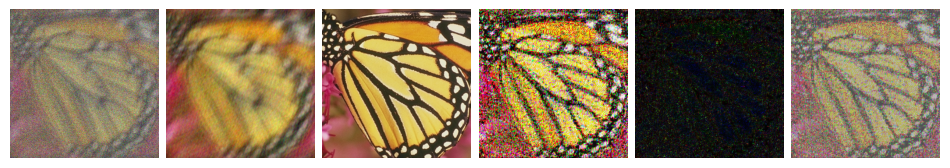

In [34]:
### ça fait de la d 

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)


# plot results
imgs = [y, x_lin, x, pula_mean, pula_var, example_sample]
plot(imgs)

100%|██████████| 1000/1000 [00:29<00:00, 34.20it/s]


Monte Carlo sampling finished! elapsed time=29.25 seconds
Iteration 999, current converge crit. = 3.57E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.63 dB
PreconULA posterior mean PSNR: 11.33 dB


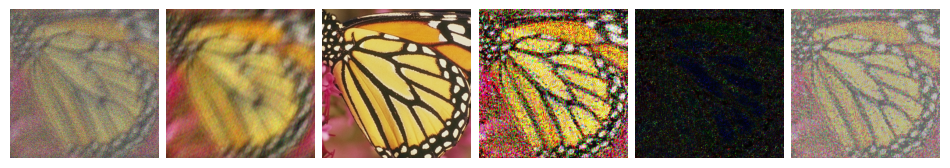

In [26]:
### Original code from Himbert, using his forward function


pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)


# plot results
imgs = [y, x_lin, x, pula_mean, pula_var, example_sample]
plot(imgs)

100%|██████████| 10000/10000 [04:56<00:00, 33.76it/s]


Monte Carlo sampling finished! elapsed time=296.26 seconds
Iteration 9999, current converge crit. = 3.73E-05, objective = 1.00E-03 
Iteration 9999, current converge crit. = 2.59E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.63 dB
PreconULA posterior mean PSNR: 11.44 dB


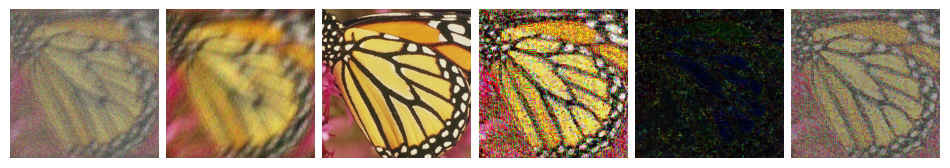

In [11]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)


# plot results
imgs = [y, x_lin, x, pula_mean, pula_var, example_sample]
plot(imgs)

In [52]:
import optuna

def objective(trial):
    gamma = 5e-4
    alpha = 1
    iterations = 4000
    sigma_denoiser = np.sqrt(2 * gamma)
    
    gamma = trial.suggest_float("gamma", 1e-5, 1e-2, log=True)
    multiple = trial.suggest_float("sigma_denoiser", 0.8, 10, log=True)
    sigma_denoiser = np.sqrt(2 * gamma) * multiple

    likelihood = dinv.optim.L2(sigma=sigma_denoiser)

    pmc_pnp = PMCPnP(prior=prior,
                    data_fidelity=likelihood,
                    max_iter=iterations,
                    gamma=gamma,
                    sigma=sigma_denoiser,
                    alpha=alpha,)
    
    pula_mean, _ = pmc_pnp(y, physics)
    
    return dinv.utils.metric.cal_psnr(x, pula_mean)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

study.best_params 

[I 2024-03-06 16:09:20,160] A new study created in memory with name: no-name-b14b8b95-1ee0-43b2-a853-2414c92e3232
100%|██████████| 4000/4000 [01:06<00:00, 60.60it/s]
[I 2024-03-06 16:10:26,188] Trial 0 finished with value: 9.701865196228027 and parameters: {'gamma': 0.0005798674267957514, 'sigma_denoiser': 3.2387610079352744}. Best is trial 0 with value: 9.701865196228027.


Monte Carlo sampling finished! elapsed time=66.02 seconds
Iteration 3999, current converge crit. = 7.96E-05, objective = 1.00E-03 
Iteration 3999, current converge crit. = 5.99E-04, objective = 1.00E-03 


100%|██████████| 4000/4000 [01:06<00:00, 59.99it/s]
[I 2024-03-06 16:11:32,881] Trial 1 finished with value: 11.702091217041016 and parameters: {'gamma': 0.0036034237096619444, 'sigma_denoiser': 7.832270161565535}. Best is trial 1 with value: 11.702091217041016.


Monte Carlo sampling finished! elapsed time=66.69 seconds
Iteration 3999, current converge crit. = 2.52E-04, objective = 1.00E-03 
Iteration 3999, current converge crit. = 4.13E-04, objective = 1.00E-03 


100%|██████████| 4000/4000 [01:06<00:00, 59.73it/s]
[I 2024-03-06 16:12:39,860] Trial 2 finished with value: 7.628241539001465 and parameters: {'gamma': 0.0002026536974789579, 'sigma_denoiser': 2.0138476665579215}. Best is trial 1 with value: 11.702091217041016.


Monte Carlo sampling finished! elapsed time=66.98 seconds
Iteration 3999, current converge crit. = 6.30E-05, objective = 1.00E-03 
Iteration 3999, current converge crit. = 7.07E-04, objective = 1.00E-03 


100%|██████████| 4000/4000 [01:07<00:00, 59.55it/s]
[I 2024-03-06 16:13:47,043] Trial 3 finished with value: 8.401317596435547 and parameters: {'gamma': 3.227779134572045e-05, 'sigma_denoiser': 6.074696991447299}. Best is trial 1 with value: 11.702091217041016.


Monte Carlo sampling finished! elapsed time=67.18 seconds
Iteration 3999, current converge crit. = 4.84E-05, objective = 1.00E-03 
Iteration 3999, current converge crit. = 7.29E-04, objective = 1.00E-03 


100%|██████████| 4000/4000 [01:07<00:00, 59.50it/s]
[I 2024-03-06 16:14:54,288] Trial 4 finished with value: 8.430436134338379 and parameters: {'gamma': 9.623263281093154e-05, 'sigma_denoiser': 4.265451482029394}. Best is trial 1 with value: 11.702091217041016.


Monte Carlo sampling finished! elapsed time=67.24 seconds
Iteration 3999, current converge crit. = 5.32E-05, objective = 1.00E-03 
Iteration 3999, current converge crit. = 6.84E-04, objective = 1.00E-03 


100%|██████████| 4000/4000 [01:07<00:00, 59.54it/s]
[I 2024-03-06 16:16:01,483] Trial 5 finished with value: 10.593080520629883 and parameters: {'gamma': 0.0006248779535716369, 'sigma_denoiser': 4.054801074883957}. Best is trial 1 with value: 11.702091217041016.


Monte Carlo sampling finished! elapsed time=67.19 seconds
Iteration 3999, current converge crit. = 1.01E-04, objective = 1.00E-03 
Iteration 3999, current converge crit. = 5.84E-04, objective = 1.00E-03 


100%|██████████| 4000/4000 [01:24<00:00, 47.40it/s]
[I 2024-03-06 16:17:25,913] Trial 6 finished with value: 7.062077522277832 and parameters: {'gamma': 2.284524143915023e-05, 'sigma_denoiser': 2.601591169951266}. Best is trial 1 with value: 11.702091217041016.


Monte Carlo sampling finished! elapsed time=84.42 seconds
Iteration 3999, current converge crit. = 4.63E-05, objective = 1.00E-03 
Iteration 3999, current converge crit. = 7.01E-04, objective = 1.00E-03 


  4%|▍         | 180/4000 [00:06<02:17, 27.86it/s]
[W 2024-03-06 16:17:32,376] Trial 7 failed with parameters: {'gamma': 0.0019712472429433826, 'sigma_denoiser': 5.012691539749584} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_369262/1328140388.py", line 22, in objective
    pula_mean, _ = pmc_pnp(y, physics)
                   ^^^^^^^^^^^^^^^^^^^
  File "/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwa

KeyboardInterrupt: 

In [59]:
iterations = int(3e3) if torch.cuda.is_available() else 10
gamma = 0.000_01

xsi = 0.99

base_sigma = np.sqrt(2 * gamma) * 10
min_sigma = np.sqrt(2 * gamma)
print(base_sigma, min_sigma)
base_alpha = 1 / (min_sigma**2)
min_alpha = 1
sigmas = torch.Tensor([max(base_sigma * (xsi**i) , min_sigma) for i in range(iterations)])
alphas = torch.Tensor([max(base_alpha * (elem**2), min_alpha) for elem in sigmas]) / 255


pmc_pnp = PMCPnPAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,)




0.0447213595499958 0.00447213595499958


In [61]:
sigmas, alphas

(tensor([0.0447, 0.0443, 0.0438,  ..., 0.0045, 0.0045, 0.0045]),
 tensor([0.3922, 0.3844, 0.3767,  ..., 0.0039, 0.0039, 0.0039]))

100%|██████████| 3000/3000 [00:26<00:00, 114.56it/s]


Monte Carlo sampling finished! elapsed time=26.24 seconds
Iteration 2999, current converge crit. = 1.14E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.75 dB
PreconULA posterior mean PSNR: 12.51 dB


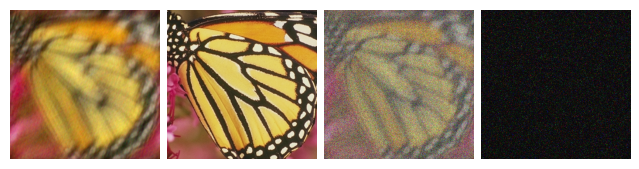

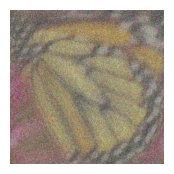

In [6]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

# plot results
imgs = [x_lin, x, pula_mean, pula_var]
plot(imgs)
example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)

plot(example_sample)


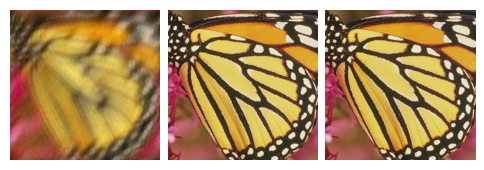

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp1805nw67 a7e023917e5ec54c63f748b782850717.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./a7e023917e5ec54c63f748b782850717.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp1805nw67/a7e023917e5ec54c63f748b782850717.log.




<Figure size 1800x400 with 3 Axes>

In [9]:
iterator = PMCPnPIterator(gamma=gamma, sigma=sigma_denoiser, alpha=alpha)

class PMCOptim(dinv.optim.OptimIterator):
    def __init__(self, iterator):
        super().__init__()
        self.iterator = iterator
        self.has_cost = True
        self.g_first = False
    
    def forward(self, X, cur_data_fidelity, cur_prior, cur_params, y, physics):
        x, z = X['est']
        x_est = self.iterator(x, y, physics, cur_data_fidelity, cur_prior)
        cost = cur_data_fidelity(x_est, y, physics)
        score = cur_prior(x_est, sigma_denoiser)
        return {'est': (x, 0), 'cost': cost}

model = dinv.optim.optim_builder(
    iteration=PMCOptim(iterator),
    prior=prior,
    data_fidelity=likelihood,
    max_iter=5e3,
    verbose=True,
)

x_model, metrics = model(y, physics, x_gt=x_true, compute_metrics=True)

dinv.utils.plotting.plot([x_model, x, x_true])
#dinv.utils.plotting.plot_curves(metrics)


In [22]:
import matplotlib.pyplot as plt
import matplotlib_inline
plt.plot(np.array(metrics['psnr'][0]))
plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpxuirp9qp a7e023917e5ec54c63f748b782850717.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./a7e023917e5ec54c63f748b782850717.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpxuirp9qp/a7e023917e5ec54c63f748b782850717.log.




<Figure size 640x480 with 1 Axes>

# test with custom MCMC

In [20]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

true_sigma = sigma
sigma_denoiser = np.sqrt(2 * gamma) * 2
print("sigma denoiser", sigma_denoiser)
nb_iterations = 2000
gamma_param = 2e-4
alpha_param = 1

denoiser = dinv.models.DRUNet(pretrained="download").to(device)
likelihood = L2(sigma=sigma_denoiser)
physics = get_blur_physics(true_sigma, device)


Selected GPU 0 with 23719 MB free memory 
sigma denoiser 0.00894427190999916


In [41]:

x_0 = y#torch.randn_like(y, device=device)
print(x_0.norm())


for it in trange(nb_iterations) :
    grad_g = physics.A_adjoint(y - physics.A(x_0)) / (sigma_denoiser**2)
    p = grad_g + (denoiser(x_0 - gamma * grad_g, sigma_denoiser) - x_0 - gamma * grad_g) / (sigma_denoiser**2)
    x_0 = x_0 - gamma_param * p + torch.randn_like(x_0, device=device) * np.sqrt(2 * gamma_param)
    x_0 = torch.clamp(x_0, 0, 1)
    print(grad_g.norm(), p.norm(), x_0.norm())
    #x_0 = torch.clamp(x_0, 0, 1)
    if it == 1000 :
        break



tensor(221.8627, device='cuda:0')


  0%|          | 10/2000 [00:00<00:21, 93.96it/s]

tensor(193845.7344, device='cuda:0') tensor(147734.3594, device='cuda:0') tensor(223.4984, device='cuda:0')
tensor(318280.7188, device='cuda:0') tensor(241012.3281, device='cuda:0') tensor(230.8061, device='cuda:0')
tensor(597782.8750, device='cuda:0') tensor(450097.8438, device='cuda:0') tensor(248.0760, device='cuda:0')
tensor(1131822.8750, device='cuda:0') tensor(850237.1875, device='cuda:0') tensor(272.3982, device='cuda:0')
tensor(1777809.1250, device='cuda:0') tensor(1334522.7500, device='cuda:0') tensor(293.9358, device='cuda:0')
tensor(2278307., device='cuda:0') tensor(1709581.2500, device='cuda:0') tensor(308.1641, device='cuda:0')
tensor(2599490.2500, device='cuda:0') tensor(1950249.2500, device='cuda:0') tensor(316.3733, device='cuda:0')
tensor(2799615.7500, device='cuda:0') tensor(2100234.5000, device='cuda:0') tensor(321.5627, device='cuda:0')
tensor(2933264.2500, device='cuda:0') tensor(2200422.5000, device='cuda:0') tensor(325.0938, device='cuda:0')
tensor(3026231.2500, 

  2%|▏         | 31/2000 [00:00<00:20, 98.18it/s]

tensor(3325337.7500, device='cuda:0') tensor(2494300.7500, device='cuda:0') tensor(335.5162, device='cuda:0')
tensor(3338393.7500, device='cuda:0') tensor(2504088.7500, device='cuda:0') tensor(335.9996, device='cuda:0')
tensor(3350585.5000, device='cuda:0') tensor(2513226., device='cuda:0') tensor(336.4158, device='cuda:0')
tensor(3361271.7500, device='cuda:0') tensor(2521234.2500, device='cuda:0') tensor(336.7025, device='cuda:0')
tensor(3370044.5000, device='cuda:0') tensor(2527810.7500, device='cuda:0') tensor(336.9545, device='cuda:0')
tensor(3378188.2500, device='cuda:0') tensor(2533914.7500, device='cuda:0') tensor(337.2277, device='cuda:0')
tensor(3386126.5000, device='cuda:0') tensor(2539863.7500, device='cuda:0') tensor(337.4765, device='cuda:0')
tensor(3393557.7500, device='cuda:0') tensor(2545435.5000, device='cuda:0') tensor(337.6555, device='cuda:0')
tensor(3399816.2500, device='cuda:0') tensor(2550126.5000, device='cuda:0') tensor(337.7880, device='cuda:0')
tensor(3405453

  3%|▎         | 53/2000 [00:00<00:19, 101.13it/s]

tensor(3456595.5000, device='cuda:0') tensor(2592703., device='cuda:0') tensor(338.3373, device='cuda:0')
tensor(3459012., device='cuda:0') tensor(2594516.2500, device='cuda:0') tensor(338.2798, device='cuda:0')
tensor(3461276., device='cuda:0') tensor(2596218., device='cuda:0') tensor(338.2258, device='cuda:0')
tensor(3463441., device='cuda:0') tensor(2597843.2500, device='cuda:0') tensor(338.1731, device='cuda:0')
tensor(3465589.5000, device='cuda:0') tensor(2599457.2500, device='cuda:0') tensor(338.1505, device='cuda:0')
tensor(3467680.7500, device='cuda:0') tensor(2601031.5000, device='cuda:0') tensor(338.1566, device='cuda:0')
tensor(3469649.5000, device='cuda:0') tensor(2602509.2500, device='cuda:0') tensor(338.1550, device='cuda:0')
tensor(3471500.5000, device='cuda:0') tensor(2603903.2500, device='cuda:0') tensor(338.0991, device='cuda:0')
tensor(3473018.2500, device='cuda:0') tensor(2605045.2500, device='cuda:0') tensor(338.0263, device='cuda:0')
tensor(3474662., device='cuda:

  4%|▍         | 75/2000 [00:00<00:18, 102.18it/s]

tensor(3487194.5000, device='cuda:0') tensor(2615694., device='cuda:0') tensor(337.7739, device='cuda:0')
tensor(3487912.5000, device='cuda:0') tensor(2616232.7500, device='cuda:0') tensor(337.7502, device='cuda:0')
tensor(3488681.2500, device='cuda:0') tensor(2616810.7500, device='cuda:0') tensor(337.7058, device='cuda:0')
tensor(3489557.7500, device='cuda:0') tensor(2617468.7500, device='cuda:0') tensor(337.6463, device='cuda:0')
tensor(3490664.2500, device='cuda:0') tensor(2618300., device='cuda:0') tensor(337.6031, device='cuda:0')
tensor(3492020.7500, device='cuda:0') tensor(2619321.7500, device='cuda:0') tensor(337.5997, device='cuda:0')
tensor(3492834.5000, device='cuda:0') tensor(2619940.5000, device='cuda:0') tensor(337.6062, device='cuda:0')
tensor(3493333., device='cuda:0') tensor(2620314.2500, device='cuda:0') tensor(337.6206, device='cuda:0')
tensor(3493726.5000, device='cuda:0') tensor(2620609.7500, device='cuda:0') tensor(337.6428, device='cuda:0')
tensor(3494107.5000, d

  5%|▍         | 97/2000 [00:00<00:18, 102.25it/s]

tensor(3498462., device='cuda:0') tensor(2624162.5000, device='cuda:0') tensor(337.8471, device='cuda:0')
tensor(3498640.7500, device='cuda:0') tensor(2624295.7500, device='cuda:0') tensor(337.8441, device='cuda:0')
tensor(3498820.5000, device='cuda:0') tensor(2624430.5000, device='cuda:0') tensor(337.8422, device='cuda:0')
tensor(3499006., device='cuda:0') tensor(2624570., device='cuda:0') tensor(337.8387, device='cuda:0')
tensor(3499192.7500, device='cuda:0') tensor(2624710., device='cuda:0') tensor(337.8373, device='cuda:0')
tensor(3499377.7500, device='cuda:0') tensor(2624848.5000, device='cuda:0') tensor(337.8388, device='cuda:0')
tensor(3499559., device='cuda:0') tensor(2624984.2500, device='cuda:0') tensor(337.8409, device='cuda:0')
tensor(3499725.2500, device='cuda:0') tensor(2625108.5000, device='cuda:0') tensor(337.8369, device='cuda:0')
tensor(3499874., device='cuda:0') tensor(2625219.5000, device='cuda:0') tensor(337.8297, device='cuda:0')
tensor(3500021., device='cuda:0') 

  6%|▌         | 119/2000 [00:01<00:18, 102.24it/s]

tensor(3501690.2500, device='cuda:0') tensor(2626578.7500, device='cuda:0') tensor(337.7271, device='cuda:0')
tensor(3501807., device='cuda:0') tensor(2626666., device='cuda:0') tensor(337.7155, device='cuda:0')
tensor(3501923.5000, device='cuda:0') tensor(2626753.7500, device='cuda:0') tensor(337.7035, device='cuda:0')
tensor(3502045., device='cuda:0') tensor(2626845., device='cuda:0') tensor(337.6901, device='cuda:0')
tensor(3502170.7500, device='cuda:0') tensor(2626939.5000, device='cuda:0') tensor(337.6786, device='cuda:0')
tensor(3502301.2500, device='cuda:0') tensor(2627037.5000, device='cuda:0') tensor(337.6677, device='cuda:0')
tensor(3502425.7500, device='cuda:0') tensor(2627130.7500, device='cuda:0') tensor(337.6571, device='cuda:0')
tensor(3502547.2500, device='cuda:0') tensor(2627222., device='cuda:0') tensor(337.6444, device='cuda:0')
tensor(3502674.7500, device='cuda:0') tensor(2627317.5000, device='cuda:0') tensor(337.6336, device='cuda:0')
tensor(3502808., device='cuda:

  7%|▋         | 141/2000 [00:01<00:18, 102.36it/s]

tensor(3504508.2500, device='cuda:0') tensor(2628688.5000, device='cuda:0') tensor(337.4657, device='cuda:0')
tensor(3504626.2500, device='cuda:0') tensor(2628776.2500, device='cuda:0') tensor(337.4528, device='cuda:0')
tensor(3504745.2500, device='cuda:0') tensor(2628865.2500, device='cuda:0') tensor(337.4413, device='cuda:0')
tensor(3504859.5000, device='cuda:0') tensor(2628950.5000, device='cuda:0') tensor(337.4296, device='cuda:0')
tensor(3504971.5000, device='cuda:0') tensor(2629034.2500, device='cuda:0') tensor(337.4195, device='cuda:0')
tensor(3505079.5000, device='cuda:0') tensor(2629114.7500, device='cuda:0') tensor(337.4090, device='cuda:0')
tensor(3505181.2500, device='cuda:0') tensor(2629191.2500, device='cuda:0') tensor(337.3982, device='cuda:0')
tensor(3505283.2500, device='cuda:0') tensor(2629268., device='cuda:0') tensor(337.3871, device='cuda:0')
tensor(3505380.5000, device='cuda:0') tensor(2629341., device='cuda:0') tensor(337.3770, device='cuda:0')
tensor(3505476.500

  8%|▊         | 163/2000 [00:01<00:17, 102.52it/s]

tensor(3506588.7500, device='cuda:0') tensor(2630241.7500, device='cuda:0') tensor(337.2337, device='cuda:0')
tensor(3506672.7500, device='cuda:0') tensor(2630304.5000, device='cuda:0') tensor(337.2241, device='cuda:0')
tensor(3506749.5000, device='cuda:0') tensor(2630361.7500, device='cuda:0') tensor(337.2135, device='cuda:0')
tensor(3506829.7500, device='cuda:0') tensor(2630421.5000, device='cuda:0') tensor(337.2013, device='cuda:0')
tensor(3506908., device='cuda:0') tensor(2630480.5000, device='cuda:0') tensor(337.1908, device='cuda:0')
tensor(3506983., device='cuda:0') tensor(2630536.7500, device='cuda:0') tensor(337.1779, device='cuda:0')
tensor(3507058.5000, device='cuda:0') tensor(2630593.7500, device='cuda:0') tensor(337.1639, device='cuda:0')
tensor(3507136.5000, device='cuda:0') tensor(2630652.5000, device='cuda:0') tensor(337.1518, device='cuda:0')
tensor(3507214.7500, device='cuda:0') tensor(2630710.7500, device='cuda:0') tensor(337.1401, device='cuda:0')
tensor(3507295.750

  9%|▉         | 185/2000 [00:01<00:17, 102.38it/s]

tensor(3508131.2500, device='cuda:0') tensor(2631397.5000, device='cuda:0') tensor(337.0018, device='cuda:0')
tensor(3508204., device='cuda:0') tensor(2631451.7500, device='cuda:0') tensor(336.9932, device='cuda:0')
tensor(3508273.5000, device='cuda:0') tensor(2631504., device='cuda:0') tensor(336.9854, device='cuda:0')
tensor(3508344.5000, device='cuda:0') tensor(2631557.2500, device='cuda:0') tensor(336.9791, device='cuda:0')
tensor(3508413.2500, device='cuda:0') tensor(2631609., device='cuda:0') tensor(336.9698, device='cuda:0')
tensor(3508475.7500, device='cuda:0') tensor(2631655.5000, device='cuda:0') tensor(336.9610, device='cuda:0')
tensor(3508537.2500, device='cuda:0') tensor(2631701.5000, device='cuda:0') tensor(336.9513, device='cuda:0')
tensor(3508595.2500, device='cuda:0') tensor(2631744.7500, device='cuda:0') tensor(336.9428, device='cuda:0')
tensor(3508652.7500, device='cuda:0') tensor(2631787.7500, device='cuda:0') tensor(336.9346, device='cuda:0')
tensor(3508707.7500, d

 10%|█         | 207/2000 [00:02<00:17, 102.24it/s]

tensor(3509396.2500, device='cuda:0') tensor(2632343.5000, device='cuda:0') tensor(336.8320, device='cuda:0')
tensor(3509452.7500, device='cuda:0') tensor(2632385.7500, device='cuda:0') tensor(336.8275, device='cuda:0')
tensor(3509513.2500, device='cuda:0') tensor(2632430.7500, device='cuda:0') tensor(336.8214, device='cuda:0')
tensor(3509575.2500, device='cuda:0') tensor(2632477.5000, device='cuda:0') tensor(336.8149, device='cuda:0')
tensor(3509633.2500, device='cuda:0') tensor(2632521.5000, device='cuda:0') tensor(336.8088, device='cuda:0')
tensor(3509689.2500, device='cuda:0') tensor(2632563., device='cuda:0') tensor(336.8036, device='cuda:0')
tensor(3509744.2500, device='cuda:0') tensor(2632604.2500, device='cuda:0') tensor(336.7985, device='cuda:0')
tensor(3509796.7500, device='cuda:0') tensor(2632643.2500, device='cuda:0') tensor(336.7927, device='cuda:0')
tensor(3509844.5000, device='cuda:0') tensor(2632679., device='cuda:0') tensor(336.7870, device='cuda:0')
tensor(3509895.500

 11%|█         | 218/2000 [00:02<00:17, 102.21it/s]

tensor(3510480.5000, device='cuda:0') tensor(2633155.5000, device='cuda:0') tensor(336.6872, device='cuda:0')
tensor(3510533.2500, device='cuda:0') tensor(2633194.7500, device='cuda:0') tensor(336.6781, device='cuda:0')
tensor(3510590.5000, device='cuda:0') tensor(2633237.5000, device='cuda:0') tensor(336.6706, device='cuda:0')
tensor(3510641.2500, device='cuda:0') tensor(2633275.5000, device='cuda:0') tensor(336.6651, device='cuda:0')
tensor(3510687.7500, device='cuda:0') tensor(2633310.2500, device='cuda:0') tensor(336.6578, device='cuda:0')
tensor(3510733.5000, device='cuda:0') tensor(2633343.7500, device='cuda:0') tensor(336.6502, device='cuda:0')
tensor(3510777., device='cuda:0') tensor(2633376.2500, device='cuda:0') tensor(336.6422, device='cuda:0')
tensor(3510820., device='cuda:0') tensor(2633408.2500, device='cuda:0') tensor(336.6360, device='cuda:0')
tensor(3510866.2500, device='cuda:0') tensor(2633442.5000, device='cuda:0') tensor(336.6286, device='cuda:0')
tensor(3510910.250

 11%|█▏        | 229/2000 [00:02<00:17, 102.29it/s]

tensor(3511374.5000, device='cuda:0') tensor(2633823.2500, device='cuda:0') tensor(336.5473, device='cuda:0')


 12%|█▏        | 240/2000 [00:02<00:17, 102.41it/s]

tensor(3511418.5000, device='cuda:0') tensor(2633856., device='cuda:0') tensor(336.5408, device='cuda:0')
tensor(3511462.2500, device='cuda:0') tensor(2633888.7500, device='cuda:0') tensor(336.5338, device='cuda:0')
tensor(3511505.7500, device='cuda:0') tensor(2633921.2500, device='cuda:0') tensor(336.5278, device='cuda:0')
tensor(3511546.2500, device='cuda:0') tensor(2633951.5000, device='cuda:0') tensor(336.5204, device='cuda:0')
tensor(3511584.2500, device='cuda:0') tensor(2633979.7500, device='cuda:0') tensor(336.5125, device='cuda:0')
tensor(3511623., device='cuda:0') tensor(2634008.7500, device='cuda:0') tensor(336.5053, device='cuda:0')
tensor(3511659.5000, device='cuda:0') tensor(2634035.7500, device='cuda:0') tensor(336.4971, device='cuda:0')
tensor(3511700.7500, device='cuda:0') tensor(2634066.7500, device='cuda:0') tensor(336.4893, device='cuda:0')
tensor(3511742., device='cuda:0') tensor(2634097.2500, device='cuda:0') tensor(336.4818, device='cuda:0')
tensor(3511782., devic

 13%|█▎        | 262/2000 [00:02<00:16, 102.54it/s]

tensor(3512271., device='cuda:0') tensor(2634493.2500, device='cuda:0') tensor(336.3671, device='cuda:0')
tensor(3512311., device='cuda:0') tensor(2634523.5000, device='cuda:0') tensor(336.3572, device='cuda:0')
tensor(3512353., device='cuda:0') tensor(2634555., device='cuda:0') tensor(336.3465, device='cuda:0')
tensor(3512397.2500, device='cuda:0') tensor(2634588.5000, device='cuda:0') tensor(336.3382, device='cuda:0')
tensor(3512442., device='cuda:0') tensor(2634622.2500, device='cuda:0') tensor(336.3282, device='cuda:0')
tensor(3512487.2500, device='cuda:0') tensor(2634656.5000, device='cuda:0') tensor(336.3181, device='cuda:0')
tensor(3512534., device='cuda:0') tensor(2634691.5000, device='cuda:0') tensor(336.3077, device='cuda:0')
tensor(3512578.5000, device='cuda:0') tensor(2634724.5000, device='cuda:0') tensor(336.2988, device='cuda:0')
tensor(3512620.5000, device='cuda:0') tensor(2634756.5000, device='cuda:0') tensor(336.2894, device='cuda:0')
tensor(3512668., device='cuda:0') 

 14%|█▍        | 284/2000 [00:02<00:16, 102.61it/s]

tensor(3513219.7500, device='cuda:0') tensor(2635205.7500, device='cuda:0') tensor(336.1817, device='cuda:0')
tensor(3513269.7500, device='cuda:0') tensor(2635243.2500, device='cuda:0') tensor(336.1722, device='cuda:0')
tensor(3513324.5000, device='cuda:0') tensor(2635284.5000, device='cuda:0') tensor(336.1638, device='cuda:0')
tensor(3513377.2500, device='cuda:0') tensor(2635324.2500, device='cuda:0') tensor(336.1546, device='cuda:0')
tensor(3513436., device='cuda:0') tensor(2635368.2500, device='cuda:0') tensor(336.1479, device='cuda:0')
tensor(3513491.2500, device='cuda:0') tensor(2635409.2500, device='cuda:0') tensor(336.1397, device='cuda:0')
tensor(3513549., device='cuda:0') tensor(2635452., device='cuda:0') tensor(336.1314, device='cuda:0')
tensor(3513600.7500, device='cuda:0') tensor(2635490.7500, device='cuda:0') tensor(336.1236, device='cuda:0')
tensor(3513660.7500, device='cuda:0') tensor(2635535.2500, device='cuda:0') tensor(336.1141, device='cuda:0')
tensor(3513722.5000, d

 15%|█▌        | 306/2000 [00:03<00:16, 102.56it/s]

tensor(3514548.5000, device='cuda:0') tensor(2636201.2500, device='cuda:0') tensor(335.9698, device='cuda:0')
tensor(3514625.7500, device='cuda:0') tensor(2636259., device='cuda:0') tensor(335.9600, device='cuda:0')
tensor(3514703.7500, device='cuda:0') tensor(2636318., device='cuda:0') tensor(335.9494, device='cuda:0')
tensor(3514781.2500, device='cuda:0') tensor(2636375.5000, device='cuda:0') tensor(335.9395, device='cuda:0')
tensor(3514856., device='cuda:0') tensor(2636431.2500, device='cuda:0') tensor(335.9281, device='cuda:0')
tensor(3514921.7500, device='cuda:0') tensor(2636480., device='cuda:0') tensor(335.9165, device='cuda:0')
tensor(3514988.5000, device='cuda:0') tensor(2636529.7500, device='cuda:0') tensor(335.9060, device='cuda:0')
tensor(3515057.7500, device='cuda:0') tensor(2636581.7500, device='cuda:0') tensor(335.8962, device='cuda:0')
tensor(3515131.5000, device='cuda:0') tensor(2636636.7500, device='cuda:0') tensor(335.8868, device='cuda:0')
tensor(3515214.7500, devic

 16%|█▋        | 328/2000 [00:03<00:16, 102.56it/s]

tensor(3516099.5000, device='cuda:0') tensor(2637362.7500, device='cuda:0') tensor(335.7576, device='cuda:0')
tensor(3516169., device='cuda:0') tensor(2637414.7500, device='cuda:0') tensor(335.7477, device='cuda:0')
tensor(3516237.5000, device='cuda:0') tensor(2637466.5000, device='cuda:0') tensor(335.7364, device='cuda:0')
tensor(3516307.5000, device='cuda:0') tensor(2637519., device='cuda:0') tensor(335.7256, device='cuda:0')
tensor(3516376., device='cuda:0') tensor(2637570.5000, device='cuda:0') tensor(335.7144, device='cuda:0')
tensor(3516447.5000, device='cuda:0') tensor(2637624.2500, device='cuda:0') tensor(335.7043, device='cuda:0')
tensor(3516520.2500, device='cuda:0') tensor(2637678.7500, device='cuda:0') tensor(335.6939, device='cuda:0')
tensor(3516592.2500, device='cuda:0') tensor(2637732.5000, device='cuda:0') tensor(335.6847, device='cuda:0')
tensor(3516664.5000, device='cuda:0') tensor(2637786.7500, device='cuda:0') tensor(335.6752, device='cuda:0')
tensor(3516737.5000, d

 18%|█▊        | 350/2000 [00:03<00:16, 102.60it/s]

tensor(3517507.2500, device='cuda:0') tensor(2638418.7500, device='cuda:0') tensor(335.5645, device='cuda:0')
tensor(3517564.2500, device='cuda:0') tensor(2638460.7500, device='cuda:0') tensor(335.5560, device='cuda:0')
tensor(3517621.7500, device='cuda:0') tensor(2638503.7500, device='cuda:0') tensor(335.5475, device='cuda:0')
tensor(3517676.5000, device='cuda:0') tensor(2638544.7500, device='cuda:0') tensor(335.5388, device='cuda:0')
tensor(3517733., device='cuda:0') tensor(2638587.2500, device='cuda:0') tensor(335.5309, device='cuda:0')
tensor(3517798.5000, device='cuda:0') tensor(2638636.5000, device='cuda:0') tensor(335.5226, device='cuda:0')
tensor(3517857.2500, device='cuda:0') tensor(2638680.5000, device='cuda:0') tensor(335.5132, device='cuda:0')
tensor(3517920., device='cuda:0') tensor(2638727.5000, device='cuda:0') tensor(335.5040, device='cuda:0')
tensor(3517987.7500, device='cuda:0') tensor(2638778.7500, device='cuda:0') tensor(335.4971, device='cuda:0')
tensor(3518060.500

 19%|█▊        | 372/2000 [00:03<00:15, 102.50it/s]

tensor(3518882.2500, device='cuda:0') tensor(2639448.2500, device='cuda:0') tensor(335.3849, device='cuda:0')
tensor(3518948.5000, device='cuda:0') tensor(2639498., device='cuda:0') tensor(335.3771, device='cuda:0')
tensor(3519013.7500, device='cuda:0') tensor(2639547.2500, device='cuda:0') tensor(335.3699, device='cuda:0')
tensor(3519077., device='cuda:0') tensor(2639594.2500, device='cuda:0') tensor(335.3628, device='cuda:0')
tensor(3519142.5000, device='cuda:0') tensor(2639643.5000, device='cuda:0') tensor(335.3551, device='cuda:0')
tensor(3519202.5000, device='cuda:0') tensor(2639688.2500, device='cuda:0') tensor(335.3473, device='cuda:0')
tensor(3519263.2500, device='cuda:0') tensor(2639733.5000, device='cuda:0') tensor(335.3394, device='cuda:0')
tensor(3519325.2500, device='cuda:0') tensor(2639780., device='cuda:0') tensor(335.3297, device='cuda:0')
tensor(3519393., device='cuda:0') tensor(2639831., device='cuda:0') tensor(335.3203, device='cuda:0')
tensor(3519463.7500, device='c

 20%|█▉        | 394/2000 [00:03<00:15, 102.58it/s]

tensor(3521434.2500, device='cuda:0') tensor(2641357.7500, device='cuda:0') tensor(335.1268, device='cuda:0')
tensor(3521452.5000, device='cuda:0') tensor(2641371.7500, device='cuda:0') tensor(335.1269, device='cuda:0')
tensor(3521468.7500, device='cuda:0') tensor(2641384.2500, device='cuda:0') tensor(335.1265, device='cuda:0')
tensor(3521483.5000, device='cuda:0') tensor(2641395.2500, device='cuda:0') tensor(335.1253, device='cuda:0')
tensor(3521498.7500, device='cuda:0') tensor(2641407., device='cuda:0') tensor(335.1244, device='cuda:0')
tensor(3521515.5000, device='cuda:0') tensor(2641419.7500, device='cuda:0') tensor(335.1234, device='cuda:0')
tensor(3521534.2500, device='cuda:0') tensor(2641434., device='cuda:0') tensor(335.1223, device='cuda:0')
tensor(3521550.5000, device='cuda:0') tensor(2641446., device='cuda:0') tensor(335.1208, device='cuda:0')
tensor(3521565.2500, device='cuda:0') tensor(2641457.2500, device='cuda:0') tensor(335.1201, device='cuda:0')
tensor(3521580.2500, d

 21%|██        | 416/2000 [00:04<00:15, 102.55it/s]

tensor(3521785.7500, device='cuda:0') tensor(2641621.5000, device='cuda:0') tensor(335.1037, device='cuda:0')
tensor(3521800., device='cuda:0') tensor(2641632.5000, device='cuda:0') tensor(335.1017, device='cuda:0')
tensor(3521813.2500, device='cuda:0') tensor(2641642.5000, device='cuda:0') tensor(335.1002, device='cuda:0')
tensor(3521826.7500, device='cuda:0') tensor(2641652.7500, device='cuda:0') tensor(335.0975, device='cuda:0')
tensor(3521839.2500, device='cuda:0') tensor(2641662., device='cuda:0') tensor(335.0952, device='cuda:0')
tensor(3521851.5000, device='cuda:0') tensor(2641671., device='cuda:0') tensor(335.0923, device='cuda:0')
tensor(3521866.5000, device='cuda:0') tensor(2641682.5000, device='cuda:0') tensor(335.0891, device='cuda:0')
tensor(3521878., device='cuda:0') tensor(2641691., device='cuda:0') tensor(335.0854, device='cuda:0')
tensor(3521889., device='cuda:0') tensor(2641699.2500, device='cuda:0') tensor(335.0822, device='cuda:0')
tensor(3521901., device='cuda:0') 

 22%|██▏       | 438/2000 [00:04<00:15, 102.56it/s]

tensor(3522084.2500, device='cuda:0') tensor(2641845.5000, device='cuda:0') tensor(335.0405, device='cuda:0')
tensor(3522102.2500, device='cuda:0') tensor(2641858.5000, device='cuda:0') tensor(335.0374, device='cuda:0')
tensor(3522120.2500, device='cuda:0') tensor(2641872., device='cuda:0') tensor(335.0352, device='cuda:0')
tensor(3522139.7500, device='cuda:0') tensor(2641886.5000, device='cuda:0') tensor(335.0325, device='cuda:0')
tensor(3522157.2500, device='cuda:0') tensor(2641899.5000, device='cuda:0') tensor(335.0292, device='cuda:0')
tensor(3522176.2500, device='cuda:0') tensor(2641913.7500, device='cuda:0') tensor(335.0266, device='cuda:0')
tensor(3522193., device='cuda:0') tensor(2641926.5000, device='cuda:0') tensor(335.0234, device='cuda:0')
tensor(3522207.7500, device='cuda:0') tensor(2641937.2500, device='cuda:0') tensor(335.0211, device='cuda:0')
tensor(3522222.5000, device='cuda:0') tensor(2641948.5000, device='cuda:0') tensor(335.0182, device='cuda:0')
tensor(3522236.500

 22%|██▏       | 449/2000 [00:04<00:15, 102.60it/s]

tensor(3522390.5000, device='cuda:0') tensor(2642075.2500, device='cuda:0') tensor(334.9864, device='cuda:0')
tensor(3522403.5000, device='cuda:0') tensor(2642084.7500, device='cuda:0') tensor(334.9843, device='cuda:0')
tensor(3522417., device='cuda:0') tensor(2642094.7500, device='cuda:0') tensor(334.9815, device='cuda:0')
tensor(3522430.2500, device='cuda:0') tensor(2642104.7500, device='cuda:0') tensor(334.9782, device='cuda:0')
tensor(3522442.7500, device='cuda:0') tensor(2642114., device='cuda:0') tensor(334.9753, device='cuda:0')
tensor(3522453.7500, device='cuda:0') tensor(2642122.5000, device='cuda:0') tensor(334.9729, device='cuda:0')
tensor(3522462., device='cuda:0') tensor(2642129., device='cuda:0') tensor(334.9701, device='cuda:0')
tensor(3522473.2500, device='cuda:0') tensor(2642137.2500, device='cuda:0') tensor(334.9677, device='cuda:0')
tensor(3522484., device='cuda:0') tensor(2642145.2500, device='cuda:0') tensor(334.9655, device='cuda:0')
tensor(3522494.5000, device='c

 23%|██▎       | 460/2000 [00:04<00:15, 102.48it/s]

tensor(3522614.7500, device='cuda:0') tensor(2642243.2500, device='cuda:0') tensor(334.9391, device='cuda:0')


 24%|██▎       | 471/2000 [00:04<00:14, 102.57it/s]

tensor(3522625.2500, device='cuda:0') tensor(2642251., device='cuda:0') tensor(334.9369, device='cuda:0')
tensor(3522637., device='cuda:0') tensor(2642259.7500, device='cuda:0') tensor(334.9343, device='cuda:0')
tensor(3522648.5000, device='cuda:0') tensor(2642268., device='cuda:0') tensor(334.9314, device='cuda:0')
tensor(3522663.7500, device='cuda:0') tensor(2642279.7500, device='cuda:0') tensor(334.9290, device='cuda:0')
tensor(3522675.2500, device='cuda:0') tensor(2642288., device='cuda:0') tensor(334.9262, device='cuda:0')
tensor(3522687.5000, device='cuda:0') tensor(2642297.5000, device='cuda:0') tensor(334.9225, device='cuda:0')
tensor(3522700.2500, device='cuda:0') tensor(2642307., device='cuda:0') tensor(334.9196, device='cuda:0')
tensor(3522713.2500, device='cuda:0') tensor(2642316.5000, device='cuda:0') tensor(334.9153, device='cuda:0')
tensor(3522727., device='cuda:0') tensor(2642326.7500, device='cuda:0') tensor(334.9111, device='cuda:0')
tensor(3522741.5000, device='cuda:

 25%|██▍       | 493/2000 [00:04<00:14, 102.63it/s]

tensor(3523065.2500, device='cuda:0') tensor(2642581., device='cuda:0') tensor(334.8416, device='cuda:0')
tensor(3523094.5000, device='cuda:0') tensor(2642603., device='cuda:0') tensor(334.8378, device='cuda:0')
tensor(3523117.7500, device='cuda:0') tensor(2642620.7500, device='cuda:0') tensor(334.8333, device='cuda:0')
tensor(3523143.5000, device='cuda:0') tensor(2642640., device='cuda:0') tensor(334.8287, device='cuda:0')
tensor(3523168., device='cuda:0') tensor(2642658.2500, device='cuda:0') tensor(334.8244, device='cuda:0')
tensor(3523192.5000, device='cuda:0') tensor(2642676.2500, device='cuda:0') tensor(334.8203, device='cuda:0')
tensor(3523216.2500, device='cuda:0') tensor(2642693.7500, device='cuda:0') tensor(334.8168, device='cuda:0')
tensor(3523239.2500, device='cuda:0') tensor(2642710.7500, device='cuda:0') tensor(334.8128, device='cuda:0')
tensor(3523264.5000, device='cuda:0') tensor(2642729.7500, device='cuda:0') tensor(334.8088, device='cuda:0')
tensor(3523287.2500, devic

 26%|██▌       | 515/2000 [00:05<00:14, 102.68it/s]

tensor(3523524., device='cuda:0') tensor(2642924., device='cuda:0') tensor(334.7560, device='cuda:0')
tensor(3523538., device='cuda:0') tensor(2642934.7500, device='cuda:0') tensor(334.7523, device='cuda:0')
tensor(3523553., device='cuda:0') tensor(2642946., device='cuda:0') tensor(334.7492, device='cuda:0')
tensor(3523568.7500, device='cuda:0') tensor(2642957.7500, device='cuda:0') tensor(334.7462, device='cuda:0')
tensor(3523582., device='cuda:0') tensor(2642967.7500, device='cuda:0') tensor(334.7430, device='cuda:0')
tensor(3523597., device='cuda:0') tensor(2642979., device='cuda:0') tensor(334.7394, device='cuda:0')
tensor(3523611., device='cuda:0') tensor(2642989.5000, device='cuda:0') tensor(334.7356, device='cuda:0')
tensor(3523624., device='cuda:0') tensor(2642999., device='cuda:0') tensor(334.7325, device='cuda:0')
tensor(3523636.7500, device='cuda:0') tensor(2643008.5000, device='cuda:0') tensor(334.7289, device='cuda:0')
tensor(3523650.7500, device='cuda:0') tensor(2643019.,

 27%|██▋       | 537/2000 [00:05<00:14, 102.71it/s]

tensor(3523819.2500, device='cuda:0') tensor(2643145.2500, device='cuda:0') tensor(334.6953, device='cuda:0')
tensor(3523827.5000, device='cuda:0') tensor(2643151.5000, device='cuda:0') tensor(334.6928, device='cuda:0')
tensor(3523838.7500, device='cuda:0') tensor(2643159.7500, device='cuda:0') tensor(334.6901, device='cuda:0')
tensor(3523851., device='cuda:0') tensor(2643169.2500, device='cuda:0') tensor(334.6873, device='cuda:0')
tensor(3523863.7500, device='cuda:0') tensor(2643178.7500, device='cuda:0') tensor(334.6849, device='cuda:0')
tensor(3523875.5000, device='cuda:0') tensor(2643187.7500, device='cuda:0') tensor(334.6812, device='cuda:0')
tensor(3523890.2500, device='cuda:0') tensor(2643199., device='cuda:0') tensor(334.6796, device='cuda:0')
tensor(3523903.5000, device='cuda:0') tensor(2643208.7500, device='cuda:0') tensor(334.6771, device='cuda:0')
tensor(3523916.7500, device='cuda:0') tensor(2643219., device='cuda:0') tensor(334.6753, device='cuda:0')
tensor(3523927.5000, d

 28%|██▊       | 559/2000 [00:05<00:14, 102.59it/s]

tensor(3524062.2500, device='cuda:0') tensor(2643327.7500, device='cuda:0') tensor(334.6491, device='cuda:0')
tensor(3524072.5000, device='cuda:0') tensor(2643335.2500, device='cuda:0') tensor(334.6473, device='cuda:0')
tensor(3524082.5000, device='cuda:0') tensor(2643342.5000, device='cuda:0') tensor(334.6460, device='cuda:0')
tensor(3524091.2500, device='cuda:0') tensor(2643349.2500, device='cuda:0') tensor(334.6436, device='cuda:0')
tensor(3524102.7500, device='cuda:0') tensor(2643357.5000, device='cuda:0') tensor(334.6413, device='cuda:0')
tensor(3524114.2500, device='cuda:0') tensor(2643366.5000, device='cuda:0') tensor(334.6395, device='cuda:0')
tensor(3524126.2500, device='cuda:0') tensor(2643375.5000, device='cuda:0') tensor(334.6385, device='cuda:0')
tensor(3524136.7500, device='cuda:0') tensor(2643383.5000, device='cuda:0') tensor(334.6361, device='cuda:0')
tensor(3524148.7500, device='cuda:0') tensor(2643392.7500, device='cuda:0') tensor(334.6339, device='cuda:0')
tensor(352

 29%|██▉       | 581/2000 [00:05<00:13, 102.61it/s]

tensor(3524260.7500, device='cuda:0') tensor(2643477.2500, device='cuda:0') tensor(334.6013, device='cuda:0')
tensor(3524267.7500, device='cuda:0') tensor(2643482.7500, device='cuda:0') tensor(334.5988, device='cuda:0')
tensor(3524276., device='cuda:0') tensor(2643488.7500, device='cuda:0') tensor(334.5961, device='cuda:0')
tensor(3524285.2500, device='cuda:0') tensor(2643495.5000, device='cuda:0') tensor(334.5931, device='cuda:0')
tensor(3524295., device='cuda:0') tensor(2643503., device='cuda:0') tensor(334.5901, device='cuda:0')
tensor(3524305.7500, device='cuda:0') tensor(2643511., device='cuda:0') tensor(334.5878, device='cuda:0')
tensor(3524315.5000, device='cuda:0') tensor(2643518.2500, device='cuda:0') tensor(334.5851, device='cuda:0')
tensor(3524325.2500, device='cuda:0') tensor(2643525.5000, device='cuda:0') tensor(334.5842, device='cuda:0')
tensor(3524334., device='cuda:0') tensor(2643532., device='cuda:0') tensor(334.5824, device='cuda:0')
tensor(3524343.2500, device='cuda:

 30%|███       | 603/2000 [00:05<00:13, 102.64it/s]

tensor(3524434.5000, device='cuda:0') tensor(2643607.7500, device='cuda:0') tensor(334.5617, device='cuda:0')
tensor(3524442.7500, device='cuda:0') tensor(2643613.7500, device='cuda:0') tensor(334.5597, device='cuda:0')
tensor(3524452.5000, device='cuda:0') tensor(2643621., device='cuda:0') tensor(334.5583, device='cuda:0')
tensor(3524460., device='cuda:0') tensor(2643626.7500, device='cuda:0') tensor(334.5566, device='cuda:0')
tensor(3524467., device='cuda:0') tensor(2643631.7500, device='cuda:0') tensor(334.5550, device='cuda:0')
tensor(3524474.5000, device='cuda:0') tensor(2643637.5000, device='cuda:0') tensor(334.5526, device='cuda:0')
tensor(3524481.7500, device='cuda:0') tensor(2643642.7500, device='cuda:0') tensor(334.5509, device='cuda:0')
tensor(3524489., device='cuda:0') tensor(2643648.2500, device='cuda:0') tensor(334.5483, device='cuda:0')
tensor(3524498.7500, device='cuda:0') tensor(2643655.5000, device='cuda:0') tensor(334.5463, device='cuda:0')
tensor(3524507.2500, devic

 31%|███▏      | 625/2000 [00:06<00:13, 102.62it/s]

tensor(3524639.2500, device='cuda:0') tensor(2643760.2500, device='cuda:0') tensor(334.5104, device='cuda:0')
tensor(3524652., device='cuda:0') tensor(2643770., device='cuda:0') tensor(334.5067, device='cuda:0')
tensor(3524664.5000, device='cuda:0') tensor(2643779.5000, device='cuda:0') tensor(334.5038, device='cuda:0')
tensor(3524678., device='cuda:0') tensor(2643789.7500, device='cuda:0') tensor(334.4996, device='cuda:0')
tensor(3524692.2500, device='cuda:0') tensor(2643800.2500, device='cuda:0') tensor(334.4962, device='cuda:0')
tensor(3524706.2500, device='cuda:0') tensor(2643811., device='cuda:0') tensor(334.4925, device='cuda:0')
tensor(3524719.5000, device='cuda:0') tensor(2643820.7500, device='cuda:0') tensor(334.4892, device='cuda:0')
tensor(3524731.2500, device='cuda:0') tensor(2643829.5000, device='cuda:0') tensor(334.4854, device='cuda:0')
tensor(3524743., device='cuda:0') tensor(2643838.2500, device='cuda:0') tensor(334.4824, device='cuda:0')
tensor(3524751.7500, device='c

 32%|███▏      | 647/2000 [00:06<00:13, 102.61it/s]

tensor(3524877., device='cuda:0') tensor(2643938.7500, device='cuda:0') tensor(334.4360, device='cuda:0')
tensor(3524887.2500, device='cuda:0') tensor(2643946.5000, device='cuda:0') tensor(334.4332, device='cuda:0')
tensor(3524895., device='cuda:0') tensor(2643952.2500, device='cuda:0') tensor(334.4318, device='cuda:0')
tensor(3524901., device='cuda:0') tensor(2643956.7500, device='cuda:0') tensor(334.4293, device='cuda:0')
tensor(3524907.7500, device='cuda:0') tensor(2643961.7500, device='cuda:0') tensor(334.4275, device='cuda:0')
tensor(3524914.5000, device='cuda:0') tensor(2643966.7500, device='cuda:0') tensor(334.4246, device='cuda:0')
tensor(3524920.2500, device='cuda:0') tensor(2643971.2500, device='cuda:0') tensor(334.4219, device='cuda:0')
tensor(3524927., device='cuda:0') tensor(2643976.2500, device='cuda:0') tensor(334.4196, device='cuda:0')
tensor(3524932.7500, device='cuda:0') tensor(2643980.5000, device='cuda:0') tensor(334.4172, device='cuda:0')
tensor(3524938.5000, devic

 33%|███▎      | 669/2000 [00:06<00:12, 102.54it/s]

tensor(3525019.7500, device='cuda:0') tensor(2644044.5000, device='cuda:0') tensor(334.3889, device='cuda:0')
tensor(3525025., device='cuda:0') tensor(2644048.5000, device='cuda:0') tensor(334.3865, device='cuda:0')
tensor(3525030.5000, device='cuda:0') tensor(2644052.2500, device='cuda:0') tensor(334.3835, device='cuda:0')
tensor(3525037.2500, device='cuda:0') tensor(2644057.5000, device='cuda:0') tensor(334.3810, device='cuda:0')
tensor(3525045.2500, device='cuda:0') tensor(2644063.5000, device='cuda:0') tensor(334.3785, device='cuda:0')
tensor(3525053.2500, device='cuda:0') tensor(2644069.2500, device='cuda:0') tensor(334.3765, device='cuda:0')
tensor(3525061.2500, device='cuda:0') tensor(2644075.2500, device='cuda:0') tensor(334.3743, device='cuda:0')
tensor(3525069., device='cuda:0') tensor(2644080.7500, device='cuda:0') tensor(334.3721, device='cuda:0')
tensor(3525076., device='cuda:0') tensor(2644086., device='cuda:0') tensor(334.3709, device='cuda:0')
tensor(3525080.5000, devic

 34%|███▍      | 680/2000 [00:06<00:12, 102.54it/s]

tensor(3525152.5000, device='cuda:0') tensor(2644143.5000, device='cuda:0') tensor(334.3528, device='cuda:0')
tensor(3525158.7500, device='cuda:0') tensor(2644148.2500, device='cuda:0') tensor(334.3510, device='cuda:0')
tensor(3525165.5000, device='cuda:0') tensor(2644153.5000, device='cuda:0') tensor(334.3487, device='cuda:0')
tensor(3525173.5000, device='cuda:0') tensor(2644159.5000, device='cuda:0') tensor(334.3461, device='cuda:0')
tensor(3525179.5000, device='cuda:0') tensor(2644164., device='cuda:0') tensor(334.3452, device='cuda:0')
tensor(3525183.2500, device='cuda:0') tensor(2644166.7500, device='cuda:0') tensor(334.3423, device='cuda:0')
tensor(3525190.7500, device='cuda:0') tensor(2644172.5000, device='cuda:0') tensor(334.3408, device='cuda:0')
tensor(3525197.5000, device='cuda:0') tensor(2644177.2500, device='cuda:0') tensor(334.3389, device='cuda:0')
tensor(3525204., device='cuda:0') tensor(2644182., device='cuda:0') tensor(334.3365, device='cuda:0')
tensor(3525210.7500, d

 35%|███▍      | 691/2000 [00:06<00:12, 102.59it/s]

tensor(3525281.7500, device='cuda:0') tensor(2644240., device='cuda:0') tensor(334.3129, device='cuda:0')


 35%|███▌      | 702/2000 [00:06<00:12, 102.55it/s]

tensor(3525287.2500, device='cuda:0') tensor(2644244.2500, device='cuda:0') tensor(334.3122, device='cuda:0')
tensor(3525291.5000, device='cuda:0') tensor(2644247.5000, device='cuda:0') tensor(334.3103, device='cuda:0')
tensor(3525297.2500, device='cuda:0') tensor(2644251.5000, device='cuda:0') tensor(334.3082, device='cuda:0')
tensor(3525303.2500, device='cuda:0') tensor(2644256., device='cuda:0') tensor(334.3066, device='cuda:0')
tensor(3525309.2500, device='cuda:0') tensor(2644260.2500, device='cuda:0') tensor(334.3046, device='cuda:0')
tensor(3525314.7500, device='cuda:0') tensor(2644264.7500, device='cuda:0') tensor(334.3029, device='cuda:0')
tensor(3525319.7500, device='cuda:0') tensor(2644268.5000, device='cuda:0') tensor(334.3021, device='cuda:0')
tensor(3525322.7500, device='cuda:0') tensor(2644270.7500, device='cuda:0') tensor(334.3003, device='cuda:0')
tensor(3525327.5000, device='cuda:0') tensor(2644274.2500, device='cuda:0') tensor(334.2988, device='cuda:0')
tensor(3525331

 36%|███▌      | 724/2000 [00:07<00:12, 102.61it/s]

tensor(3525410., device='cuda:0') tensor(2644336.7500, device='cuda:0') tensor(334.2751, device='cuda:0')
tensor(3525416.2500, device='cuda:0') tensor(2644341.2500, device='cuda:0') tensor(334.2738, device='cuda:0')
tensor(3525422.2500, device='cuda:0') tensor(2644346.2500, device='cuda:0') tensor(334.2719, device='cuda:0')
tensor(3525428.5000, device='cuda:0') tensor(2644351., device='cuda:0') tensor(334.2703, device='cuda:0')
tensor(3525432.5000, device='cuda:0') tensor(2644354., device='cuda:0') tensor(334.2689, device='cuda:0')
tensor(3525438., device='cuda:0') tensor(2644358., device='cuda:0') tensor(334.2668, device='cuda:0')
tensor(3525444., device='cuda:0') tensor(2644362.5000, device='cuda:0') tensor(334.2645, device='cuda:0')
tensor(3525448.2500, device='cuda:0') tensor(2644366., device='cuda:0') tensor(334.2625, device='cuda:0')
tensor(3525452.5000, device='cuda:0') tensor(2644369., device='cuda:0') tensor(334.2607, device='cuda:0')
tensor(3525459., device='cuda:0') tensor(2

 37%|███▋      | 746/2000 [00:07<00:12, 102.62it/s]

tensor(3525543.7500, device='cuda:0') tensor(2644436.7500, device='cuda:0') tensor(334.2368, device='cuda:0')
tensor(3525549.7500, device='cuda:0') tensor(2644441.2500, device='cuda:0') tensor(334.2358, device='cuda:0')
tensor(3525555., device='cuda:0') tensor(2644445.2500, device='cuda:0') tensor(334.2340, device='cuda:0')
tensor(3525561.7500, device='cuda:0') tensor(2644450.2500, device='cuda:0') tensor(334.2320, device='cuda:0')
tensor(3525570., device='cuda:0') tensor(2644456.5000, device='cuda:0') tensor(334.2305, device='cuda:0')
tensor(3525575.7500, device='cuda:0') tensor(2644460.5000, device='cuda:0') tensor(334.2287, device='cuda:0')
tensor(3525584., device='cuda:0') tensor(2644466.7500, device='cuda:0') tensor(334.2269, device='cuda:0')
tensor(3525593.2500, device='cuda:0') tensor(2644473.7500, device='cuda:0') tensor(334.2261, device='cuda:0')
tensor(3525600.5000, device='cuda:0') tensor(2644479., device='cuda:0') tensor(334.2244, device='cuda:0')
tensor(3525608., device='c

 38%|███▊      | 768/2000 [00:07<00:12, 102.55it/s]

tensor(3525689.2500, device='cuda:0') tensor(2644545.5000, device='cuda:0') tensor(334.2016, device='cuda:0')
tensor(3525696.7500, device='cuda:0') tensor(2644551., device='cuda:0') tensor(334.2003, device='cuda:0')
tensor(3525703.5000, device='cuda:0') tensor(2644556.2500, device='cuda:0') tensor(334.1977, device='cuda:0')
tensor(3525709.5000, device='cuda:0') tensor(2644560.7500, device='cuda:0') tensor(334.1967, device='cuda:0')
tensor(3525716.5000, device='cuda:0') tensor(2644566.2500, device='cuda:0') tensor(334.1945, device='cuda:0')
tensor(3525725.2500, device='cuda:0') tensor(2644572.7500, device='cuda:0') tensor(334.1927, device='cuda:0')
tensor(3525732.2500, device='cuda:0') tensor(2644578., device='cuda:0') tensor(334.1904, device='cuda:0')
tensor(3525738.5000, device='cuda:0') tensor(2644582.7500, device='cuda:0') tensor(334.1892, device='cuda:0')
tensor(3525745.2500, device='cuda:0') tensor(2644587.7500, device='cuda:0') tensor(334.1878, device='cuda:0')
tensor(3525752.750

 40%|███▉      | 790/2000 [00:07<00:11, 102.55it/s]

tensor(3525845.2500, device='cuda:0') tensor(2644662.7500, device='cuda:0') tensor(334.1695, device='cuda:0')
tensor(3525848., device='cuda:0') tensor(2644665., device='cuda:0') tensor(334.1685, device='cuda:0')
tensor(3525852.7500, device='cuda:0') tensor(2644668.5000, device='cuda:0') tensor(334.1678, device='cuda:0')
tensor(3525856.5000, device='cuda:0') tensor(2644671.2500, device='cuda:0') tensor(334.1663, device='cuda:0')
tensor(3525860.7500, device='cuda:0') tensor(2644675., device='cuda:0') tensor(334.1646, device='cuda:0')
tensor(3525866.2500, device='cuda:0') tensor(2644679., device='cuda:0') tensor(334.1629, device='cuda:0')
tensor(3525870.2500, device='cuda:0') tensor(2644682.2500, device='cuda:0') tensor(334.1628, device='cuda:0')
tensor(3525874.2500, device='cuda:0') tensor(2644685.2500, device='cuda:0') tensor(334.1620, device='cuda:0')
tensor(3525878.7500, device='cuda:0') tensor(2644688.5000, device='cuda:0') tensor(334.1614, device='cuda:0')
tensor(3525881.2500, devic

 41%|████      | 812/2000 [00:07<00:11, 102.52it/s]

tensor(3525953.2500, device='cuda:0') tensor(2644745., device='cuda:0') tensor(334.1446, device='cuda:0')
tensor(3525962., device='cuda:0') tensor(2644751.7500, device='cuda:0') tensor(334.1434, device='cuda:0')
tensor(3525970.7500, device='cuda:0') tensor(2644758., device='cuda:0') tensor(334.1414, device='cuda:0')
tensor(3525980.5000, device='cuda:0') tensor(2644765.2500, device='cuda:0') tensor(334.1402, device='cuda:0')
tensor(3525988.7500, device='cuda:0') tensor(2644771.2500, device='cuda:0') tensor(334.1385, device='cuda:0')
tensor(3525997., device='cuda:0') tensor(2644777.5000, device='cuda:0') tensor(334.1365, device='cuda:0')
tensor(3526005.5000, device='cuda:0') tensor(2644784., device='cuda:0') tensor(334.1345, device='cuda:0')
tensor(3526015.2500, device='cuda:0') tensor(2644791.2500, device='cuda:0') tensor(334.1324, device='cuda:0')
tensor(3526026., device='cuda:0') tensor(2644799.5000, device='cuda:0') tensor(334.1293, device='cuda:0')
tensor(3526038.7500, device='cuda:

 42%|████▏     | 834/2000 [00:08<00:11, 102.35it/s]

tensor(3526246.2500, device='cuda:0') tensor(2644964.5000, device='cuda:0') tensor(334.0884, device='cuda:0')
tensor(3526273.5000, device='cuda:0') tensor(2644985.2500, device='cuda:0') tensor(334.0834, device='cuda:0')
tensor(3526301.2500, device='cuda:0') tensor(2645006., device='cuda:0') tensor(334.0798, device='cuda:0')
tensor(3526326., device='cuda:0') tensor(2645024.2500, device='cuda:0') tensor(334.0754, device='cuda:0')
tensor(3526354.5000, device='cuda:0') tensor(2645045.5000, device='cuda:0') tensor(334.0700, device='cuda:0')
tensor(3526383., device='cuda:0') tensor(2645066.7500, device='cuda:0') tensor(334.0644, device='cuda:0')
tensor(3526415.7500, device='cuda:0') tensor(2645091., device='cuda:0') tensor(334.0574, device='cuda:0')
tensor(3526455., device='cuda:0') tensor(2645120.2500, device='cuda:0') tensor(334.0498, device='cuda:0')
tensor(3526500.2500, device='cuda:0') tensor(2645154., device='cuda:0') tensor(334.0405, device='cuda:0')
tensor(3526561.7500, device='cuda:

 43%|████▎     | 856/2000 [00:08<00:11, 102.24it/s]

tensor(3527330., device='cuda:0') tensor(2645773.5000, device='cuda:0') tensor(333.9674, device='cuda:0')
tensor(3527336., device='cuda:0') tensor(2645778., device='cuda:0') tensor(333.9663, device='cuda:0')
tensor(3527340.7500, device='cuda:0') tensor(2645781.7500, device='cuda:0') tensor(333.9656, device='cuda:0')
tensor(3527345.5000, device='cuda:0') tensor(2645785.2500, device='cuda:0') tensor(333.9651, device='cuda:0')
tensor(3527350.5000, device='cuda:0') tensor(2645789., device='cuda:0') tensor(333.9640, device='cuda:0')
tensor(3527355., device='cuda:0') tensor(2645792.5000, device='cuda:0') tensor(333.9634, device='cuda:0')
tensor(3527358.2500, device='cuda:0') tensor(2645795., device='cuda:0') tensor(333.9630, device='cuda:0')
tensor(3527361.2500, device='cuda:0') tensor(2645797., device='cuda:0') tensor(333.9628, device='cuda:0')
tensor(3527364.2500, device='cuda:0') tensor(2645799.2500, device='cuda:0') tensor(333.9623, device='cuda:0')
tensor(3527368.2500, device='cuda:0') 

 44%|████▍     | 878/2000 [00:08<00:10, 102.06it/s]

tensor(3527416.5000, device='cuda:0') tensor(2645839.5000, device='cuda:0') tensor(333.9497, device='cuda:0')
tensor(3527421., device='cuda:0') tensor(2645842.7500, device='cuda:0') tensor(333.9485, device='cuda:0')
tensor(3527426.5000, device='cuda:0') tensor(2645847., device='cuda:0') tensor(333.9473, device='cuda:0')
tensor(3527432.5000, device='cuda:0') tensor(2645851.5000, device='cuda:0') tensor(333.9474, device='cuda:0')
tensor(3527437.2500, device='cuda:0') tensor(2645855., device='cuda:0') tensor(333.9464, device='cuda:0')
tensor(3527443.7500, device='cuda:0') tensor(2645859.7500, device='cuda:0') tensor(333.9441, device='cuda:0')
tensor(3527451.7500, device='cuda:0') tensor(2645865.7500, device='cuda:0') tensor(333.9431, device='cuda:0')
tensor(3527456.7500, device='cuda:0') tensor(2645869.5000, device='cuda:0') tensor(333.9416, device='cuda:0')
tensor(3527462., device='cuda:0') tensor(2645873.5000, device='cuda:0') tensor(333.9391, device='cuda:0')
tensor(3527467.7500, devic

 45%|████▌     | 900/2000 [00:08<00:10, 102.13it/s]

tensor(3527568., device='cuda:0') tensor(2645952.2500, device='cuda:0') tensor(333.9138, device='cuda:0')
tensor(3527577., device='cuda:0') tensor(2645959., device='cuda:0') tensor(333.9122, device='cuda:0')
tensor(3527586.7500, device='cuda:0') tensor(2645966.2500, device='cuda:0') tensor(333.9109, device='cuda:0')
tensor(3527596., device='cuda:0') tensor(2645973.2500, device='cuda:0') tensor(333.9099, device='cuda:0')
tensor(3527605.2500, device='cuda:0') tensor(2645980.2500, device='cuda:0') tensor(333.9078, device='cuda:0')
tensor(3527612.2500, device='cuda:0') tensor(2645985.7500, device='cuda:0') tensor(333.9062, device='cuda:0')
tensor(3527619.7500, device='cuda:0') tensor(2645991., device='cuda:0') tensor(333.9048, device='cuda:0')
tensor(3527626., device='cuda:0') tensor(2645995.7500, device='cuda:0') tensor(333.9027, device='cuda:0')
tensor(3527633., device='cuda:0') tensor(2646001.2500, device='cuda:0') tensor(333.9012, device='cuda:0')
tensor(3527639.7500, device='cuda:0') 

 46%|████▌     | 911/2000 [00:08<00:10, 102.16it/s]

tensor(3527734., device='cuda:0') tensor(2646077., device='cuda:0') tensor(333.8801, device='cuda:0')
tensor(3527741.7500, device='cuda:0') tensor(2646082.7500, device='cuda:0') tensor(333.8782, device='cuda:0')
tensor(3527751.7500, device='cuda:0') tensor(2646090.2500, device='cuda:0') tensor(333.8765, device='cuda:0')
tensor(3527761.5000, device='cuda:0') tensor(2646097.7500, device='cuda:0') tensor(333.8753, device='cuda:0')
tensor(3527770.7500, device='cuda:0') tensor(2646104.7500, device='cuda:0') tensor(333.8729, device='cuda:0')
tensor(3527778.5000, device='cuda:0') tensor(2646110.7500, device='cuda:0') tensor(333.8710, device='cuda:0')
tensor(3527787., device='cuda:0') tensor(2646117., device='cuda:0') tensor(333.8679, device='cuda:0')
tensor(3527797.2500, device='cuda:0') tensor(2646124.7500, device='cuda:0') tensor(333.8658, device='cuda:0')
tensor(3527806.5000, device='cuda:0') tensor(2646131.5000, device='cuda:0') tensor(333.8638, device='cuda:0')
tensor(3527815., device='c

 46%|████▌     | 922/2000 [00:09<00:10, 102.17it/s]

tensor(3528001.7500, device='cuda:0') tensor(2646279.2500, device='cuda:0') tensor(333.8217, device='cuda:0')


 47%|████▋     | 933/2000 [00:09<00:10, 102.19it/s]

tensor(3528022.7500, device='cuda:0') tensor(2646295.2500, device='cuda:0') tensor(333.8186, device='cuda:0')
tensor(3528040.5000, device='cuda:0') tensor(2646308.7500, device='cuda:0') tensor(333.8147, device='cuda:0')
tensor(3528058.7500, device='cuda:0') tensor(2646322.2500, device='cuda:0') tensor(333.8104, device='cuda:0')
tensor(3528077.5000, device='cuda:0') tensor(2646336.5000, device='cuda:0') tensor(333.8070, device='cuda:0')
tensor(3528098.2500, device='cuda:0') tensor(2646352., device='cuda:0') tensor(333.8045, device='cuda:0')
tensor(3528115.5000, device='cuda:0') tensor(2646365.2500, device='cuda:0') tensor(333.8017, device='cuda:0')
tensor(3528132.2500, device='cuda:0') tensor(2646378., device='cuda:0') tensor(333.7984, device='cuda:0')
tensor(3528147.5000, device='cuda:0') tensor(2646389.5000, device='cuda:0') tensor(333.7952, device='cuda:0')
tensor(3528162.7500, device='cuda:0') tensor(2646401., device='cuda:0') tensor(333.7914, device='cuda:0')
tensor(3528176.7500, d

 48%|████▊     | 955/2000 [00:09<00:10, 102.18it/s]

tensor(3528368., device='cuda:0') tensor(2646555.2500, device='cuda:0') tensor(333.7448, device='cuda:0')
tensor(3528383., device='cuda:0') tensor(2646566.7500, device='cuda:0') tensor(333.7411, device='cuda:0')
tensor(3528401., device='cuda:0') tensor(2646580., device='cuda:0') tensor(333.7382, device='cuda:0')
tensor(3528416.7500, device='cuda:0') tensor(2646592., device='cuda:0') tensor(333.7347, device='cuda:0')
tensor(3528431., device='cuda:0') tensor(2646602.7500, device='cuda:0') tensor(333.7315, device='cuda:0')
tensor(3528446.2500, device='cuda:0') tensor(2646614.2500, device='cuda:0') tensor(333.7280, device='cuda:0')
tensor(3528464.5000, device='cuda:0') tensor(2646628., device='cuda:0') tensor(333.7246, device='cuda:0')
tensor(3528479.5000, device='cuda:0') tensor(2646639.5000, device='cuda:0') tensor(333.7215, device='cuda:0')
tensor(3528493.7500, device='cuda:0') tensor(2646650.2500, device='cuda:0') tensor(333.7182, device='cuda:0')
tensor(3528507.5000, device='cuda:0') 

 49%|████▉     | 977/2000 [00:09<00:10, 102.10it/s]

tensor(3528657., device='cuda:0') tensor(2646773., device='cuda:0') tensor(333.6810, device='cuda:0')
tensor(3528665.2500, device='cuda:0') tensor(2646779.5000, device='cuda:0') tensor(333.6793, device='cuda:0')
tensor(3528673.7500, device='cuda:0') tensor(2646786., device='cuda:0') tensor(333.6778, device='cuda:0')
tensor(3528678., device='cuda:0') tensor(2646789., device='cuda:0') tensor(333.6754, device='cuda:0')
tensor(3528683.2500, device='cuda:0') tensor(2646793.2500, device='cuda:0') tensor(333.6736, device='cuda:0')
tensor(3528689.5000, device='cuda:0') tensor(2646798., device='cuda:0') tensor(333.6706, device='cuda:0')
tensor(3528697.7500, device='cuda:0') tensor(2646804.2500, device='cuda:0') tensor(333.6683, device='cuda:0')
tensor(3528706.7500, device='cuda:0') tensor(2646811., device='cuda:0') tensor(333.6656, device='cuda:0')
tensor(3528715.5000, device='cuda:0') tensor(2646817.7500, device='cuda:0') tensor(333.6632, device='cuda:0')
tensor(3528725.7500, device='cuda:0') 

 50%|█████     | 1000/2000 [00:09<00:09, 102.19it/s]

tensor(3528815.5000, device='cuda:0') tensor(2646892.7500, device='cuda:0') tensor(333.6382, device='cuda:0')
tensor(3528823.5000, device='cuda:0') tensor(2646898.7500, device='cuda:0') tensor(333.6360, device='cuda:0')
tensor(3528830.2500, device='cuda:0') tensor(2646903.7500, device='cuda:0') tensor(333.6347, device='cuda:0')
tensor(3528836.2500, device='cuda:0') tensor(2646908.2500, device='cuda:0') tensor(333.6341, device='cuda:0')
tensor(3528842.2500, device='cuda:0') tensor(2646912.7500, device='cuda:0') tensor(333.6325, device='cuda:0')
tensor(3528847.7500, device='cuda:0') tensor(2646916.5000, device='cuda:0') tensor(333.6317, device='cuda:0')
tensor(3528852.2500, device='cuda:0') tensor(2646920.2500, device='cuda:0') tensor(333.6304, device='cuda:0')
tensor(3528856.5000, device='cuda:0') tensor(2646923.2500, device='cuda:0') tensor(333.6292, device='cuda:0')
tensor(3528860.5000, device='cuda:0') tensor(2646926.2500, device='cuda:0') tensor(333.6276, device='cuda:0')
tensor(352

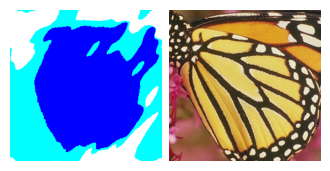

In [43]:
plot([x_0, x_true])

# test

In [43]:
denoiser = dinv.models.DRUNet(pretrained="download")
# denoiser = dinv.models.DiffUNet(pretrained='download', large_model=False)
#denoiser = dinv.models.DnCNN(pretrained="download_lipschitz")

32.211029052734375


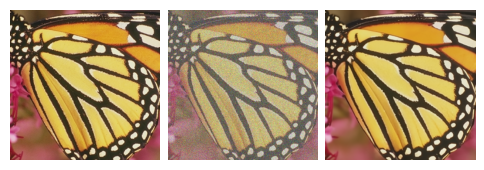

In [45]:
noise = dinv.physics.GaussianNoise(sigma=0.1)

y = noise(x)

out = denoiser.forward(y.cpu(), 0.1)
print(dinv.utils.metric.cal_psnr(out, x.cpu()))

plot([x, y, out])

In [27]:
denoiser(y.cpu(), 0.1)

tensor([[[[0.1751, 0.2339, 0.3546,  ..., 0.2773, 0.2721, 0.2586],
          [0.1490, 0.1764, 0.2441,  ..., 0.2868, 0.2889, 0.2863],
          [0.3340, 0.2188, 0.1784,  ..., 0.2792, 0.2777, 0.2773],
          ...,
          [0.3598, 0.3459, 0.3588,  ..., 0.6075, 0.6015, 0.5957],
          [0.3519, 0.3478, 0.3841,  ..., 0.6082, 0.6039, 0.6003],
          [0.3478, 0.3563, 0.4021,  ..., 0.6102, 0.6087, 0.6073]],

         [[0.1300, 0.1748, 0.2832,  ..., 0.2027, 0.1972, 0.1862],
          [0.1102, 0.1299, 0.1889,  ..., 0.2136, 0.2168, 0.2135],
          [0.3027, 0.1870, 0.1415,  ..., 0.2139, 0.2143, 0.2126],
          ...,
          [0.1174, 0.1075, 0.1085,  ..., 0.3956, 0.3929, 0.3899],
          [0.1101, 0.1084, 0.1214,  ..., 0.3951, 0.3934, 0.3907],
          [0.1158, 0.1126, 0.1347,  ..., 0.3946, 0.3946, 0.3925]],

         [[0.0652, 0.0972, 0.1783,  ..., 0.1830, 0.1768, 0.1702],
          [0.0449, 0.0588, 0.1014,  ..., 0.1931, 0.1941, 0.1912],
          [0.2460, 0.1267, 0.0748,  ..., 0